# Алгоритм кодирования и декодирования методом Шеннона-Фано

Это являтся улучшенной версией моего прошлого алгоритма, который находится по этой ссылке: https://github.com/Omegon226/Encoder_Decoder_Shennon_Fano_IPython

Этот алгоритм позволяет преобразовать текст в набор 0 и едениц, так называемый шифр, а так же для этого шифра создать кодировку, в которой хранится символ и частота его повторения в тесте. На основе частоты символов будет работать наш алгоритм, а именно будет строить дерево кодировок, в котором будет определяться какому сиволу достанется та или иная комбинация 0 и 1. И на основе полученной кодировки мы сможем декодировать или закодировать информацию.

## Пример 

Имея тыблицу для в которой будет иемться символы и их частота мы можем построить дерево кодировок и поределить код для каждого символа.

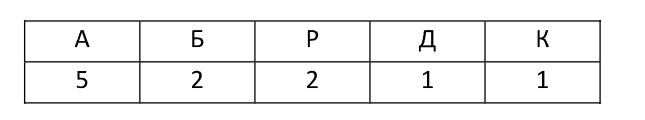

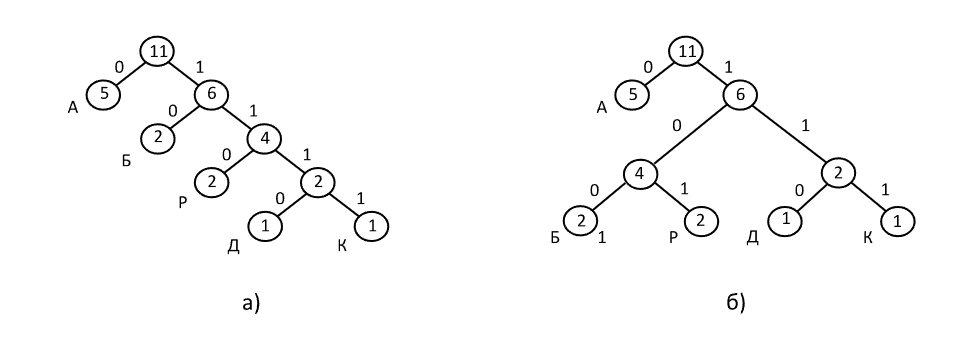

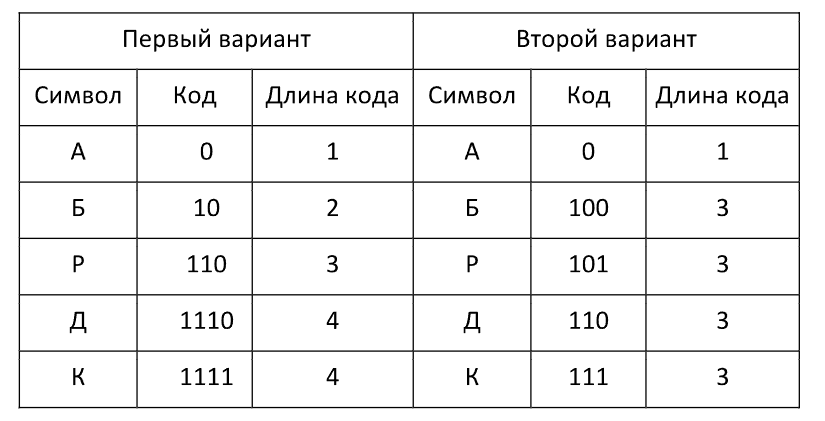

## С какими файлами работает моя система

Моя система работает с 3 файлами: файл с кодировкой, файл с тестом и файл с шифром. Примеры того, что хранится в этих файлах можно увидеть ниже.

## Что и как это работает?

Моя программа позволяет (как я ранее говорил) кодировать и декодировать текст. Для кодирования текста нужно указать пути для всех 3 файлов (текст, шифр, кодировка), либо в можно ввести текст, который нужно декодировать через аргумент функции и в данном случае нам понадобится только 2 файла(шифр, кодировка). Для декодирования уже требуется все 3 файла (текст, шифр, кодировка), причём файл с кодировкой и шифром должны быть уже заполнены информацией. В результате работы все изменения запишутся в нужные для этого файлы, а результаты работы будут выведены в консоль программы.

In [52]:
import numpy as np
import pandas as pd

In [53]:
class ShennonFanoEncoderDecoderOptimized():

    def __init__(self, file_for_ascii='ascii-table.csv', code_of_symbol_len=8):
        """
        Конструктор класса, в котором задаются пустые значения для работы с ними
        self.code - np.array в котором в каждом элементе массива хранится отрывок из шифра
        self.encoding - pd.DataFrame в котором хранится информация о кодировке
                        (Для каждого символа есть частота и код этого символа)
        self.text - np.array в котором в каждом элементе массива хранится символ из текста
        self.ascii_table - pd.DataFrame в котором кранится символ и его кодировка в ASCII
        """

        self.code = np.array([])
        self.encoding = None
        self.text = np.array([])

        pass

    def encode(self, text=None, file_for_code=None, file_for_encoding=None, file_for_text=None,
               code_of_symbol_len=8):
        """
        Эта функция с помощью которой можно будет произвести кодирование текста
        text - информация с текстом, при отсутствии файла будет взята информация отсюда
        file_for_code - путь к файлу с шифром
        file_for_encoding - путь к файлу с кодировкой
        file_for_text - путь к файлу с тестом
        code_of_symbol_len - длина для кода каждого символа, если хоть один код символа
                             будет отличаться от этого значения, то будет выведена ошибка.
                             Под эту переменную будет подгоняться создающиеся коды символов
                             и сам шифр, т.к. он не будет разделён пробелами
        """
        # Обновляем информацию в классе
        self.__init__(code_of_symbol_len=code_of_symbol_len)

        # Смотрим каким образом мы получаем информацию о тексте из переменной или из файла
        if (text != None):
            self.text = np.array(list(text))
        else:
            self.get_text_from_file(file_for_text)

        # С помощью этой функции создаём таблицу для кодировки
        self.__create_encoding_DataFrame(np.unique(self.text), pd.Series(self.text).value_counts())

        # Активируем алгоритм построения рекурсивного дерева кодировки
        self.__activate_algorithm(0, self.encoding.shape[0] - 1)

        # Подстраиваем полученную кодировку символов под определённый размер
        for i in range(self.encoding.shape[0]):
            if (code_of_symbol_len > len(self.encoding.iloc[i, 1])):
                # self.encoding.iloc[i, 1] = self.encoding.iloc[i, 1] + \
                #                           "0" * (code_of_symbol_len - len(self.encoding.iloc[i, 1]))
                self.encoding.iloc[i, 1] = "0" * (code_of_symbol_len - len(self.encoding.iloc[i, 1])) + \
                                           self.encoding.iloc[i, 1]

        # После этого создаём шифр из нашего текста
        for i in self.text:
            self.code = np.append(self.code, self.encoding.loc[i, "Код символа"])

        # После записываем полученную информацию в файлы
        self.set_code_for_file(file_for_code)
        self.set_encoding_for_file(file_for_encoding)
        pass

    def decode(self, file_for_code=None, file_for_encoding=None, file_for_text=None,
               code_of_symbol_len=8):
        """
        Эта функция с помощью которой можно будет произвести декодирование текста
        file_for_code - путь к файлу с шифром
        file_for_encoding - путь к файлу с кодировкой
        file_for_text - путь к файлу с тестом
        code_of_symbol_len - длина для кода каждого символа, если хоть один код символа
                             будет отличаться от этого значения, то будет выведена ошибка.
                             Под эту переменную будет подгоняться создающиеся коды символов
                             и сам шифр, т.к. он не будет разделён пробелами
        """
        # Обновляем информацию в классе
        self.__init__(code_of_symbol_len=code_of_symbol_len)

        # Читаем информацию о кодировке и шифре и создаём DataFrame с информацией о кодировке
        self.get_encoding_from_file(file_for_encoding)
        self.get_code_from_file(file_for_code, code_of_symbol_len)

        # Активируем алгоритм построения рекурсивного дерева кодировки
        self.__activate_algorithm(0, self.encoding.shape[0] - 1)

        # Подстраиваем полученную кодировку символов под определённый размер
        for i in range(self.encoding.shape[0]):
            if (code_of_symbol_len > len(self.encoding.iloc[i, 1])):
                # self.encoding.iloc[i, 1] = self.encoding.iloc[i, 1] + \
                #                           "0" * (code_of_symbol_len - len(self.encoding.iloc[i, 1]))
                self.encoding.iloc[i, 1] = "0" * (code_of_symbol_len - len(self.encoding.iloc[i, 1])) + \
                                           self.encoding.iloc[i, 1]

        # После этого создаём текст из нашего шифра
        for i in self.code:
            self.text = np.append(self.text,
                                  self.encoding.loc[self.encoding["Код символа"] == i]["Код символа"].index.values)

        # После записываем полученную информацию в файлы
        self.set_text_for_file(file_for_text)
        pass

    def get_code_from_file(self, file_for_code, code_of_symbol_len=8):
        """
        Эта функция позволяет вытянуть и преобразовать информацию из файла с шифром
        file_for_code - путь к файлу с шифром
        """
        # Переменная для чтения шифра из файла в текстовом формате
        str_code = ""
        with open(file_for_code, 'r', encoding="utf-8") as file:
            # Считываем текст и убираем в конце знак \n
            str_code = file.readline().replace("\n", '')

        # После дробим наш шифр на массив из символов
        code_ = np.array(list(str_code))
        # И после собираем наш шифр в строки длинной code_of_symbol_len
        for i in range(0, len(code_), code_of_symbol_len):
            self.code = np.append(self.code, "".join(code_[i:i + code_of_symbol_len]))
        pass

    def set_code_for_file(self, file_for_code):
        """
        Эта функция позволяет записать информацию с шифром в файл
        file_for_code - путь к файлу с шифром
        """
        # Записываем информацию о шифре в файл
        with open(file_for_code, 'w', encoding="utf-8") as file:
            file.write("".join(self.code))
        pass

    def get_encoding_from_file(self, file_for_encoding):
        """
        Эта функция позволяет вытянуть и преобразовать информацию из файла с кодировкой
        file_for_encoding - путь к файлу с кодировкой
        """
        # Создаём массивы в котором будет храниться информация об символах в таблице кодировок
        # А так же частота с появлением этих символов
        indexes, frec_info = list(), list()

        # Открываем файл и читаем из него информацию
        with open(file_for_encoding, 'r', encoding="utf-8") as file:
            for line in file:
                # Первым элементом строки будет буква, а остальные - это частота (кроме \n)
                indexes.extend(line[0])
                frec_info.extend([int(line[:0:-1].replace("\n", ''))])

        # После с помощью полученных данных создаём таблицу кодировок
        self.__create_encoding_DataFrame(indexes, frec_info)
        pass

    def set_encoding_for_file(self, file_for_encoding):
        """
        Эта функция позволяет записать информацию с кодировкой в файл
        file_for_encoding - путь к файлу с кодировкой
        """
        # Открываем файл для записи кодировок, после чего построчно записываем символ и его частоту
        with open(file_for_encoding, 'w', encoding="utf-8") as file:
            indexes = self.encoding.index.tolist()
            for i in range(self.encoding.shape[0]):
                file.write(f"{indexes[i]}{self.encoding.iloc[i, 0]}\n")
        pass

    def get_text_from_file(self, file_for_text):
        """
        Эта функция позволяет вытянуть и преобразовать информацию из файла с текстом
        file_for_text - путь к файлу с тестом
        """
        # Переменная для чтения текста
        str_text = ""
        with open(file_for_text, 'r', encoding="utf-8") as file:
            # Считываем текст и убираем в конце знак \n
            str_text = file.readline().replace("\n", '')

        # После чего дробим наш текст на символы
        self.text = np.array(list(str_text))
        pass

    def set_text_for_file(self, file_for_text):
        """
        Эта функция позволяет записать информацию с текстом в файл
        file_for_text - путь к файлу с тестом
        """
        # Записываем информацию о тексте в файл
        with open(file_for_text, 'w', encoding="utf-8") as file:
            file.write("".join(self.text))
        pass

    def visualize_information(self):
        """
        Позволяет визуализировать информацию
        """

        print(self.encoding)
        print(*self.code)
        print("".join(self.text))
        pass

    def __activate_algorithm(self, start, end):
        """
        Часть рекурсивной функции, которая вставляет нужные символы (0 или 1) в таблицу
        start, end - интервал индексов строк таблицы кодировки, который будет просматриваться
                     для того, чтобы найти точку разделения, чтобы построить два листка в дереве
        """
        # Это метод, который позволяет строить ветви из листка дерева кодировки
        if (start < end):
            # Для начала определим по какой части таблицы кодировок пройдёт деление
            temp = self.__partition_of_recursion(start, end)
            # После чего строим две ветви с примерно поделёнными пополам частотами
            self.__activate_algorithm(start, temp - 1)
            self.__activate_algorithm(temp, end)
        pass

    def __partition_of_recursion(self, start, end):
        """
        Рекурсивная функция, которая строит дерево кодов
        start, end - интервал в котором будет рассматриваться для построения ответвлений в дереве
        """
        # Индекс по которому будет разделена таблицы.
        # При чём у каждой части таблицы будет примерно равная сумма частот
        split_index = start
        # Эта переменная определяет в каком месте лучше всего произвести разделение таблицы (она равна бесконечности)
        previous_delta = float('inf')
        # Будем проходить по таблице снизу вверх, но если конечный индекс меньше стартового
        if (start < end):
            for i in range(start, end + 1):
                # Определяем сумму частот выше и ниже индекса разделения
                up = self.encoding.iloc[start:i, 0].sum()
                down = self.encoding.iloc[i:end + 1, 0].sum()
                # И расчитываем разность сумм
                delta = abs(up - down)
                # Если сумма верхней части больше нижней, то ищем строчку разделения
                if (up >= down):
                    # Если дельта в прошлой итерации была меньше, то мы возьмём прошлую строчку разделения
                    if (previous_delta < delta):
                        split_index = i - 1
                        break
                    else:
                        split_index = i
                        break
                # Иначе сохраняем дельту для следующей итерации
                else:
                    previous_delta = delta

            # Изменяем код для каждого символа, который мы рассматривали
            for i in range(start, split_index):
                self.encoding.iloc[i, 1] = '1' + self.encoding.iloc[i, 1]
            for i in range(split_index, end + 1):
                self.encoding.iloc[i, 1] = '0' + self.encoding.iloc[i, 1]

        # Возвращаем индекс разделения
        return (split_index)
        pass

    def __create_encoding_DataFrame(self, indexes, frequencies):
        """
        Позволяет единообразным способом создать DataFrame для кодировки
        indexes - индексы, которые мы зададим в наш DataFrame
        frequencies - массив с частотой для каждого символа
        """
        # Создаём наш DataFrame(таблицу) с кодировками
        self.encoding = pd.DataFrame(index=indexes, columns=["Частота", "Код символа"])
        # После чего в столбец с Частотой записываем информацию
        self.encoding["Частота"] = pd.Series(index=indexes, data=frequencies)
        # И очищаем столбец с Кодом для символов
        self.encoding.iloc[:, 1] = ""
        # Отсортировываем строки таблицы по Частоте символов
        self.encoding = self.encoding.sort_values(by="Частота", ascending=False)
        pass


SFEDO = ShennonFanoEncoderDecoderOptimized()

In [1]:
file_text_path = "text.bin"
file_encoding_path = "encoding.bin"
file_code_path = "code.bin"

## Такая информация будет находится в текстовых файлах

text.bin - текст, который требуется закодировать

encoding.bin - кодировка для шифра

code.bin - зашифрованный текст (шифр)

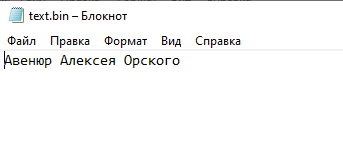

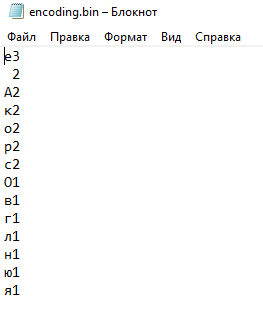

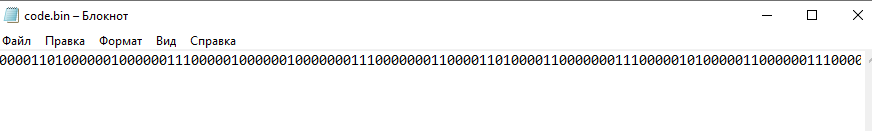

In [36]:
with open(file_text_path, 'w', encoding="utf-8") as file:
    file.write("абракадабра")

In [37]:
SFEDO.encode(file_for_code=file_code_path, file_for_encoding=file_encoding_path, file_for_text=file_text_path)
SFEDO.visualize_information()

   Частота Код символа
а        5    00000001
б        2    00000110
р        2    00000010
д        1    00000100
к        1    00000000
00000001 00000110 00000010 00000001 00000000 00000001 00000100 00000001 00000110 00000010 00000001
абракадабра


In [38]:
SFEDO.decode(file_for_code=file_code_path, file_for_encoding=file_encoding_path, file_for_text=file_text_path)
SFEDO.visualize_information()

   Частота Код символа
а        5    00000001
б        2    00000110
р        2    00000010
д        1    00000100
к        1    00000000
00000001 00000110 00000010 00000001 00000000 00000001 00000100 00000001 00000110 00000010 00000001
абракадабра


In [39]:
SFEDO.encode(text="Авенюр Алексея Орского", file_for_encoding=file_encoding_path, file_for_code=file_code_path)
SFEDO.visualize_information()

   Частота Код символа
е        3    00000111
         2    00000011
А        2    00001101
к        2    00000101
о        2    00000001
р        2    00001110
с        2    00000110
О        1    00001010
в        1    00000010
г        1    00011100
л        1    00001100
н        1    00000100
ю        1    00001000
я        1    00000000
00001101 00000010 00000111 00000100 00001000 00001110 00000011 00001101 00001100 00000111 00000101 00000110 00000111 00000000 00000011 00001010 00001110 00000110 00000101 00000001 00011100 00000001
Авенюр Алексея Орского


In [40]:
SFEDO.decode(file_for_code=file_code_path, file_for_encoding=file_encoding_path, file_for_text=file_text_path)
SFEDO.visualize_information()

   Частота Код символа
е        3    00000111
         2    00000011
А        2    00001101
к        2    00000101
о        2    00000001
р        2    00001110
с        2    00000110
О        1    00001010
в        1    00000010
г        1    00011100
л        1    00001100
н        1    00000100
ю        1    00001000
я        1    00000000
00001101 00000010 00000111 00000100 00001000 00001110 00000011 00001101 00001100 00000111 00000101 00000110 00000111 00000000 00000011 00001010 00001110 00000110 00000101 00000001 00011100 00000001
Авенюр Алексея Орского
